## Installing relevant packages

In [1]:
!pip install duckdb --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
!pip install python-gdcm
!pip install pylibjpeg
!pip install pylibjpeg-libjpeg==2.2.0
!pip install pylibjpeg-openjpeg==2.3.0
!pip install matplotlib==3.10.3
!pip install scikit-learn==1.7.0
!pip install polars --no-index --find-links=/kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/polars_pkg
!pip install pydicom

Looking in links: /kaggle/input/polars-and-duckdb/kaggle/working/mysitepackages/duck_pkg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 46.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 38.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.16.1 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.3 which is incompatible.
bigframes 2.8.0 re

In [2]:
from pydicom import dcmread
from pydicom.dataset import FileDataset, FileMetaDataset
from pydicom.uid import generate_uid, ImplicitVRLittleEndian
import nibabel as nib

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import polars as pl
import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import pickle
import gc
import ctypes
from pathlib import Path
import logging
import json
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

2025-09-01 15:02:48.294585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756738968.553935      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756738968.624371      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setting polars configs to view the dataframes better

In [3]:
pl.Config(fmt_str_lengths=1000)
pl.Config.set_tbl_rows(1000)

polars.config.Config

## Load the previously prepared training metadata

In [4]:
df_all_data = pl.read_parquet('/kaggle/input/rsna-aneurysm-train-metadata-suman/full_training_data.parquet')
print("Shape of training metadata", df_all_data.shape)
df_all_data.columns

Shape of training metadata (1001346, 24)


['file_name',
 'image_shape',
 'coordinates_x',
 'coordinates_y',
 'coordinates_f',
 'aneurysm_present_in_series',
 'aneurysm_present_in_image',
 'seriesinstanceuid',
 'patientage',
 'patientsex',
 'modality',
 'left_infraclinoid_internal_carotid_artery',
 'right_infraclinoid_internal_carotid_artery',
 'left_supraclinoid_internal_carotid_artery',
 'right_supraclinoid_internal_carotid_artery',
 'left_middle_cerebral_artery',
 'right_middle_cerebral_artery',
 'anterior_communicating_artery',
 'left_anterior_cerebral_artery',
 'right_anterior_cerebral_artery',
 'left_posterior_communicating_artery',
 'right_posterior_communicating_artery',
 'basilar_tip',
 'other_posterior_circulation']

In [33]:
df_all_data.head(5)

file_name,image_shape,coordinates_x,coordinates_y,coordinates_f,aneurysm_present_in_series,aneurysm_present_in_image,seriesinstanceuid,patientage,patientsex,modality,left_infraclinoid_internal_carotid_artery,right_infraclinoid_internal_carotid_artery,left_supraclinoid_internal_carotid_artery,right_supraclinoid_internal_carotid_artery,left_middle_cerebral_artery,right_middle_cerebral_artery,anterior_communicating_artery,left_anterior_cerebral_artery,right_anterior_cerebral_artery,left_posterior_communicating_artery,right_posterior_communicating_artery,basilar_tip,other_posterior_circulation
str,str,f64,f64,i32,i64,i32,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.50109132199445951854133683565774892169.dcm""","""(512, 512)""",256.300637,146.099363,0,1,1,"""1.2.826.0.1.3680043.8.498.10602156717395509282545203380100998253""",40,"""Female""","""CTA""",0,0,0,0,0,1,0,1,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.46546299230498892201063080673910592618.dcm""","""(512, 512)""",258.326172,197.485714,0,1,1,"""1.2.826.0.1.3680043.8.498.10603321067992496978932502160661673268""",35,"""Male""","""CTA""",0,0,0,0,0,0,1,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.22013535645164965059058737013866577944.dcm""","""(320, 260)""",145.686159,157.433479,0,1,1,"""1.2.826.0.1.3680043.8.498.10607580708371334840797048741181101985""",68,"""Male""","""MRI T2""",0,0,0,0,0,0,0,0,0,0,0,0,1
"""1.2.826.0.1.3680043.8.498.10665853855746359070265541252480337151.dcm""","""(150, 480, 480)""",null,null,null,0,0,"""1.2.826.0.1.3680043.8.498.10618752182981309163840057940806925305""",52,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.73808789234996291374936109664786479598.dcm""","""(768, 696)""",null,null,null,0,0,"""1.2.826.0.1.3680043.8.498.10623075849681650687943932638488393349""",60,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,0,0,0


## Checking the segmentation data

In [5]:
image_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/1.2.826.0.1.3680043.8.498.62169558538817009391695314359016512306.nii'
img = nib.load(image_path)

In [6]:
image_array_data = img.get_fdata()
print(img.get_fdata().shape)

(296, 512, 512)


In [37]:
print(img.dataobj[..., 1].shape)

(296, 512)


In [40]:
image_array_data[:,:,0].shape

(296, 512)

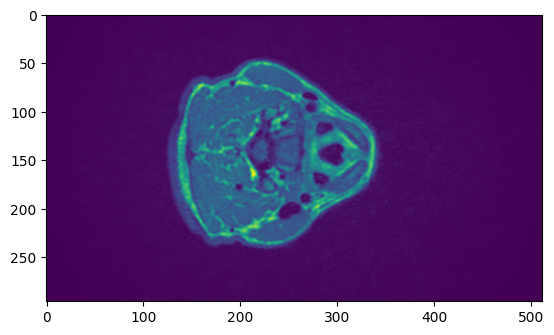

In [47]:
test = image_array_data[:,:,8]
plt.imshow(test)
plt.show()

In [52]:
test[:,8].shape

(296,)

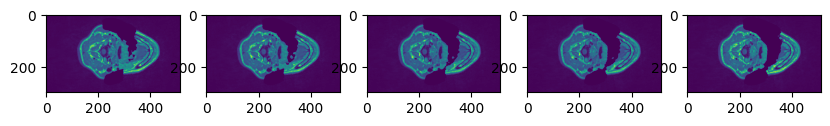

In [54]:
for i in range(5):
    plt.subplot(5, 5,i + 1)
    plt.imshow(image_array_data[:,:,58 + i])
    plt.gcf().set_size_inches(10, 10)
plt.show()

In [58]:
print(img.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 296 512 512   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  0.5 0.5 0.5 0.  0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : -0.004389839
quatern_d       : 0.0
qoffset_x       : -71.12565
qoffset_y       : -127.75
qoffset_z       : -92.06918
srow_x          : [ 4.

In [57]:
print(img.header['dim'])

[  3 296 512 512   1   1   1   1]


In [25]:
class NiiRecord:
    """
    Memory-efficient class for storing NII metadata using __slots__
    """
    __slots__ = ['file_name', 'image_shape']
    
    def __init__(self, file_name, image_shape):
        self.file_name = file_name
        self.image_shape = image_shape
    
    def to_dict(self):
        return {slot: getattr(self, slot) for slot in self.__slots__}

In [26]:
def get_nii_shape_name(seg_file):
    """
    Process all the nii files and get the file name and shape of the image array
    """
    try:
        data = []
        #print("inside the function call", type(seg_files))
        #for seg_file in seg_files:
        try:
            # Read NII file
            img = nib.load(seg_file)
            #original_shape = str(img.get_fdata().shape)
            original_shape = str((img.header['dim'][1], img.header['dim'][2], img.header['dim'][3]))
            
            # Create record
            record = NiiRecord(seg_file.name, original_shape)
            
            data.append(record.to_dict())
            
        except Exception as e:
            print(f"Error processing file {seg_file}: {e}")
            #continue
                
        return data
        
    except Exception as e:
        print(f"Error processing files : {e}")
        return []

In [27]:
mp.cpu_count()

4

In [28]:
def create_nii_dataset(root_folder, num_processes=None, chunk_size=60):
    """
    Create dataset with nii files
    """
    schema = {
        'file_name': pl.Utf8,
        'image_shape': pl.String
    }
    
    temp_dir = Path("temp_nii_chunks")
    temp_dir.mkdir(exist_ok=True)

    if not num_processes:
        num_processes = mp.cpu_count()

    seg_files = list(Path(root_folder).glob("*.nii*"))
    
    # Process folders in parallel
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        for i in range(0, len(seg_files), chunk_size):
            chunk_seg_files = seg_files[i:i+chunk_size]
            chunk_data = []
            print("before the function call")
            futures = [
                executor.submit(
                    get_nii_shape_name, 
                    Path(seg_file)
                )
                for seg_file in chunk_seg_files
            ]
            
            for future in tqdm(futures, 
                             desc=f"Processing chunk {i//chunk_size + 1}/{(len(seg_files)-1)//chunk_size + 1}"):
                chunk_data.extend(future.result())
            
            if chunk_data:
                chunk_df = pl.DataFrame(
                    chunk_data,
                    schema=schema,
                    infer_schema_length=None
                )
                
                chunk_df.write_parquet(
                    temp_dir / f"nii_metadata_chunk_{i//chunk_size}.parquet",
                    compression="snappy"
                )
                
                del chunk_data
                del chunk_df
    
    # Combine chunks
    print("\nCombining chunks...")
    chunk_files = list(temp_dir.glob("nii_metadata_chunk_*.parquet"))
    final_nii_df = pl.concat([
        pl.scan_parquet(str(chunk_file))
        for chunk_file in chunk_files
    ]).collect()
    
    # Clean up temporary files
    for f in chunk_files:
        f.unlink()
    temp_dir.rmdir()
    
    return final_nii_df

In [30]:
seg_files_root_path = '/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations'

try:
    full_nii_df = create_nii_dataset(
        seg_files_root_path
    )
except Exception as e:
    print(f"Error: {e}")

before the function call


Processing chunk 1/6: 100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


before the function call


Processing chunk 2/6: 100%|██████████| 60/60 [00:41<00:00,  1.44it/s]


before the function call


Processing chunk 3/6: 100%|██████████| 60/60 [00:28<00:00,  2.07it/s]


before the function call


Processing chunk 4/6: 100%|██████████| 60/60 [00:33<00:00,  1.81it/s]


before the function call


Processing chunk 5/6: 100%|██████████| 60/60 [00:36<00:00,  1.65it/s]


before the function call


Processing chunk 6/6: 100%|██████████| 56/56 [00:44<00:00,  1.27it/s]


Combining chunks...


In [31]:
full_nii_df.shape

(356, 2)

In [32]:
full_nii_df.head(5)

file_name,image_shape
str,str
"""1.2.826.0.1.3680043.8.498.67256382079119118825371537284628604044.nii""","""(260, 320, 36)"""
"""1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485_cowseg.nii""","""(1024, 1024, 136)"""
"""1.2.826.0.1.3680043.8.498.12914952223659958493995413641114579279.nii""","""(310, 320, 30)"""
"""1.2.826.0.1.3680043.8.498.11999987145696510072091906561590137848.nii""","""(696, 768, 188)"""
"""1.2.826.0.1.3680043.8.498.11936548827981649628619858103408216131.nii""","""(512, 512, 25)"""


In [59]:
dd.sql("select t1.* from (select * from df_all_data where aneurysm_present_in_image = 1)t1 \
    left join full_nii_df t2 \
    on t1.seriesinstanceuid = replace(t2.file_name, '.nii','') \
    where t2.file_name is not null \
").pl()

file_name,image_shape,coordinates_x,coordinates_y,coordinates_f,aneurysm_present_in_series,aneurysm_present_in_image,seriesinstanceuid,patientage,patientsex,modality,left_infraclinoid_internal_carotid_artery,right_infraclinoid_internal_carotid_artery,left_supraclinoid_internal_carotid_artery,right_supraclinoid_internal_carotid_artery,left_middle_cerebral_artery,right_middle_cerebral_artery,anterior_communicating_artery,left_anterior_cerebral_artery,right_anterior_cerebral_artery,left_posterior_communicating_artery,right_posterior_communicating_artery,basilar_tip,other_posterior_circulation
str,str,f64,f64,i32,i64,i32,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""1.2.826.0.1.3680043.8.498.95946011283542019796878868558979812269.dcm""","""(512, 512)""",231.40005,216.357059,0,1,1,"""1.2.826.0.1.3680043.8.498.75016896260047968433534297207591136672""",67,"""Female""","""MRA""",0,0,0,0,0,0,0,0,0,0,1,0,0
"""1.2.826.0.1.3680043.8.498.12527743344533905334575066534856521576.dcm""","""(512, 512)""",276.441673,263.137114,0,1,1,"""1.2.826.0.1.3680043.8.498.61152918475243358118286003299125054478""",38,"""Female""","""CTA""",0,0,0,0,0,0,0,0,0,0,0,0,1
"""1.2.826.0.1.3680043.8.498.18458610576013839258744392316952422218.dcm""","""(512, 512)""",203.891932,198.079453,0,1,1,"""1.2.826.0.1.3680043.8.498.39640919070091958876744231048011388614""",68,"""Female""","""CTA""",0,0,0,0,0,1,1,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.73922869926815108680082897176387092867.dcm""","""(512, 512)""",265.461651,185.325726,0,1,1,"""1.2.826.0.1.3680043.8.498.39640919070091958876744231048011388614""",68,"""Female""","""CTA""",0,0,0,0,0,1,1,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.13135098617890605299446497834572889774.dcm""","""(512, 512)""",262.928105,231.459695,0,1,1,"""1.2.826.0.1.3680043.8.498.80461517820710375402982229582943598734""",30,"""Female""","""CTA""",0,0,1,0,0,0,0,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.12295490583553242167208446690635471024.dcm""","""(512, 512)""",259.088274,206.019048,0,1,1,"""1.2.826.0.1.3680043.8.498.65011208113835286935212080363533579671""",59,"""Male""","""CTA""",0,0,0,0,0,0,1,0,0,0,0,0,0
"""1.2.826.0.1.3680043.8.498.10203947660516610435169665374324788717.dcm""","""(512, 512)""",302.976431,199.111111,0,1,1,"""1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430""",63,"""Female""","""CTA""",0,0,1,1,0,0,0,0,0,0,1,0,0
"""1.2.826.0.1.3680043.8.498.25704136491953389991324569512138261675.dcm""","""(512, 512)""",219.367003,195.6633,0,1,1,"""1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430""",63,"""Female""","""CTA""",0,0,1,1,0,0,0,0,0,0,1,0,0
"""1.2.826.0.1.3680043.8.498.51144608687590097599404828043878939744.dcm""","""(512, 512)""",221.090909,218.074074,0,1,1,"""1.2.826.0.1.3680043.8.498.52363954882447190271251269039176558430""",63,"""Female""","""CTA""",0,0,1,1,0,0,0,0,0,0,1,0,0
